In [14]:
%matplotlib inline

# Optimizing geometric parameters

The pybamm.InputParameter is a powerful feature that enables efficient model reuse. It allows you to run multiple simulations with different parameter values without rebuilding the model, which significantly reduces computational overhead. However, it is not compatible with the standard meshes and finite volume code available in pybamm. This notebook shows how to use an alternative mesh implemented to allow for the use of pybamm.InputParameter. Unfortunately, this mesh is not compatible with the standard pybamm models, so custom models must be implemented for use. This limitation may be removed in future versions of pybamm.

In [15]:
import pybamm
import numpy as np
import matplotlib.pyplot as plt

domain_left = "left domain"
domain_right = "right domain"

## The model

The model we will use is a one dimensional model of diffusion in cartesian coordinates. The model has two domains (left and right) with different diffusion coefficients, $D_l$ and $D_r$, and lengths. It is parameterized by the x coordinate of the left, right, and middle points, denoted $L_{min}$, $L_{mid}$, and $L_{max}$.

In [63]:
phi_left = pybamm.Variable("phi_left", domain=domain_left)
x_left = pybamm.SpatialVariable("x", domain=domain_left, coord_sys="cartesian")

phi_right = pybamm.Variable("phi_right", domain=domain_right)
x_right = pybamm.SpatialVariable("x", domain=domain_right, coord_sys="cartesian")


class TwoTankModel(pybamm.BaseModel):
    def __init__(self):
        super().__init__()
        x = pybamm.concatenation(x_left, x_right)
        D_left = pybamm.Parameter("D_l")
        D_right = pybamm.Parameter("D_r")

        left_flux = -D_left * pybamm.grad(phi_left)
        right_flux = -D_right * pybamm.grad(phi_right)
        flux = pybamm.concatenation(left_flux, right_flux)
        source_left = pybamm.PrimaryBroadcast(pybamm.Scalar(10), domain_left)
        source_right = pybamm.PrimaryBroadcast(pybamm.Scalar(0), domain_right)
        source = pybamm.concatenation(source_left, source_right)

        self.rhs = {
            phi_left: -pybamm.div(left_flux) + source_left,
            phi_right: -pybamm.div(right_flux) + source_right,
        }
        self.initial_conditions = {phi_left: 0, phi_right: 0}
        self.boundary_conditions = {
            phi_left: {
                "left": (pybamm.Scalar(0), "Dirichlet"),
                "right": (
                    (D_right / D_left)
                    * pybamm.boundary_gradient(phi_right, side="left"),
                    "Neumann",
                ),
            },
            phi_right: {
                "left": (pybamm.boundary_value(phi_left, side="right"), "Dirichlet"),
                "right": (pybamm.Scalar(0), "Dirichlet"),
            },
        }
        phi = pybamm.concatenation(phi_left, phi_right)
        my_grad_phi = pybamm.grad(phi)
        self.variables = {
            "my_grad_phi": my_grad_phi,
            "phi_left": phi_left,
            "phi_right": phi_right,
            "phi": phi,
            "source_left": source_left,
            "source_right": source_right,
            "source": source,
        }

        # define geometry
        grad_phi_left = pybamm.grad(phi_left)
        grad_phi_right = pybamm.grad(phi_right)
        self.variables.update(
            {
                "x": x,
                "grad_phi_left": grad_phi_left,
                "grad_phi_right": grad_phi_right,
                "left_flux": left_flux,
                "right_flux": right_flux,
                "flux": flux,
            }
        )

## Non-symbolic mesh

We begin by showing how this process would work without using the symbolic mesh. We will use the default mesh, which is a uniform mesh with 50 points. We put the code in a function to show difference in time needed to change the parameters later on.

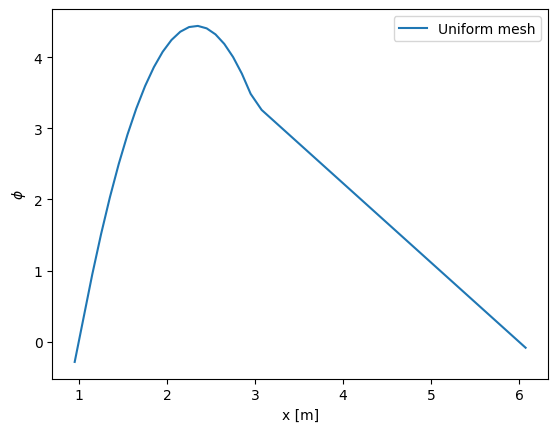

In [64]:
fig, ax = plt.subplots()

T = 10

## Uniform mesh
model = TwoTankModel()
submesh_types = {
    "left domain": pybamm.Uniform1DSubMesh,
    "right domain": pybamm.Uniform1DSubMesh,
}
var_pts = {x_left: 20, x_right: 20}
param = pybamm.ParameterValues({"D_l": 2, "D_r": 6})
param.process_model(model)
# solve
t = np.linspace(0, T, 100)
spatial_methods = {
    "left domain": pybamm.FiniteVolume(),
    "right domain": pybamm.FiniteVolume(),
}


def solve_model_with_uniform_mesh(L_min, L_mid, L_max):
    geometry = {
        "left domain": {
            x_left: {"min": pybamm.Scalar(L_min), "max": pybamm.Scalar(L_mid)}
        },
        "right domain": {
            x_right: {"min": pybamm.Scalar(L_mid), "max": pybamm.Scalar(L_max)}
        },
    }
    # mesh and discretise
    param.process_geometry(geometry)
    mesh = pybamm.Mesh(geometry, submesh_types, var_pts)

    disc = pybamm.Discretisation(mesh, spatial_methods)
    built_model = disc.process_model(model, inplace=False)
    solver = pybamm.CasadiSolver()
    solution = solver.solve(built_model, t)
    return solution


solution = solve_model_with_uniform_mesh(1, 3, 6)
ax.plot(solution["x"](t=T), solution["phi"](t=T), label="Uniform mesh")
ax.set_xlabel("x [m]")
ax.set_ylabel(r"$\phi$")
ax.legend()

## Symbolic mesh

We now show how to use the symbolic mesh to optimize the geometric parameters. The only difference in the two codes is that we must use the pybamm.SymbolicUniform1DSubMesh as the submesh type.

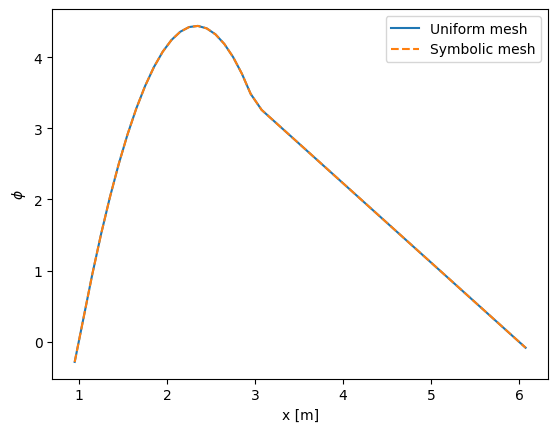

In [65]:
# this is here so that both are shown in the plot
fig, ax = plt.subplots()
ax.plot(solution["x"](t=T), solution["phi"](t=T), label="Uniform mesh")
ax.set_xlabel("x [m]")
ax.set_ylabel(r"$\phi$")
ax.legend()

T = 10
model_symbolic = TwoTankModel()
L_min = pybamm.InputParameter("L_min")
L_mid = pybamm.InputParameter("L_mid")
L_max = pybamm.InputParameter("L_max")
geometry_symbolic = {
    "left domain": {x_left: {"min": L_min, "max": L_mid}},
    "right domain": {x_right: {"min": L_mid, "max": L_max}},
}


# mesh and discretise
submesh_types = {
    "left domain": pybamm.SymbolicUniform1DSubMesh,
    "right domain": pybamm.SymbolicUniform1DSubMesh,
}
var_pts = {x_left: 20, x_right: 20}

param = pybamm.ParameterValues({"D_l": 2, "D_r": 6})
param.process_model(model_symbolic)
param.process_geometry(geometry_symbolic)

mesh = pybamm.Mesh(geometry_symbolic, submesh_types, var_pts)

spatial_methods = {
    "left domain": pybamm.FiniteVolume(),
    "right domain": pybamm.FiniteVolume(),
}
disc = pybamm.Discretisation(mesh, spatial_methods)
disc.process_model(model_symbolic)

# solve
solver = pybamm.CasadiSolver()

t = np.linspace(0, T, 100)


def solve_model_with_symbolic_mesh(L_min, L_mid, L_max):
    solution = solver.solve(
        model_symbolic, t, inputs={"L_min": L_min, "L_mid": L_mid, "L_max": L_max}
    )
    return solution


solution = solve_model_with_symbolic_mesh(1, 3, 6)
ax.plot(solution["x"](t=T), solution["phi"](t=T), label="Symbolic mesh", linestyle="--")
ax.legend()

# Showing the difference in time needed to change the parameters

Finally, we show the difference in time needed to change the parameters. Using the symbolic mesh results in a ~10x speedup due to the omission of the model build and discretisation steps. While this speedup is relatively small for one iteration, it becomes significant when iterating over many parameter values such as in large parameter sweeps or optimization problems.

In [66]:
import timeit

time_uniform = timeit.timeit(lambda: solve_model_with_uniform_mesh(1, 3, 5), number=100)
time_symbolic = timeit.timeit(
    lambda: solve_model_with_symbolic_mesh(1, 3, 5), number=100
)
print(f"Time for uniform mesh: {time_uniform} seconds")
print(f"Time for symbolic mesh: {time_symbolic} seconds")
print(f"Ratio: {time_uniform / time_symbolic}")

Time for uniform mesh: 0.9784301669569686 seconds
Time for symbolic mesh: 0.08917787508107722 seconds
Ratio: 10.97166944230748
